In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
raw_data = pd.read_csv('../data/external/data_2.csv')
raw_data.head(3)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0


In [12]:
# convert created_at to datetime and actual_delivery_time to datetime
raw_data['created_at'] = pd.to_datetime(raw_data['created_at'])
raw_data['actual_delivery_time'] = pd.to_datetime(raw_data['actual_delivery_time'])


In [14]:
# cal delivery duration in minutes
raw_data['delivery_duration'] = (raw_data['actual_delivery_time'] - raw_data['created_at']).dt.total_seconds() / 60.0
raw_data[['created_at', 'actual_delivery_time', 'delivery_duration']].head(3)

,created_at,actual_delivery_time,delivery_duration
0,2015-02-06 22:24:17,2015-02-06 23:11:17,47.0
1,2015-02-10 21:49:25,2015-02-10 22:33:25,44.0
2,2015-02-16 00:11:35,2015-02-16 01:06:35,55.0


In [15]:
# let us try to undersand each feature 

raw_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration'],
      dtype='object')

In [81]:
cat_cols = ['market_id', 'store_primary_category','order_protocol']

num_cols = ['total_items','subtotal', 'num_distinct_items', 'min_item_price','max_item_price',
            'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', ]

creatred_numcols = ['day_of_week', 'week_of_year', 'hour_of_day', 'minute_of_hour', 
                    'is_holiday', 'is_weekend','is_long_weekend']

target_col = 'delivery_duration'

In [16]:
raw_data['market_id'].value_counts(dropna=False) # 6 categories and no missing values

market_id
2.0    53469
4.0    46222
1.0    37115
3.0    21075
5.0    17258
6.0      638
Name: count, dtype: int64

In [23]:
import numpy as np

# overall mean
overall_mean = raw_data['delivery_duration'].mean()

# sum of squares between groups
ss_between = sum(
    len(group) * (group['delivery_duration'].mean() - overall_mean) ** 2
    for _, group in raw_data.groupby('market_id')
)

# total sum of squares
ss_total = sum(
    (raw_data['delivery_duration'] - overall_mean) ** 2
)

eta_squared = ss_between / ss_total
print(f"Eta squared (η²): {eta_squared:.4f}")

eta = np.sqrt(eta_squared)
print(f"Correlation ratio (η): {eta:.4f}")



Eta squared (η²): 0.0355
Correlation ratio (η): 0.1883


In [30]:
# convert created at into -> which day, week, min of the day, hour of the day, add if is a holiday or not 

import holidays
import datetime

india_holidays = holidays.India()

processed_data = raw_data.copy()

processed_data['day_of_week'] = processed_data['created_at'].dt.dayofweek
processed_data['week_of_year'] = processed_data['created_at'].dt.isocalendar().week
processed_data['hour_of_day'] = processed_data['created_at'].dt.hour
processed_data['minute_of_hour'] = processed_data['created_at'].dt.minute

# Check if the date is a holiday
processed_data['is_holiday'] = processed_data['created_at'].dt.date.apply(lambda x: x in india_holidays).astype(int) 


# add saturday and sunday as weekend
processed_data['is_weekend'] = processed_data['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

# add long weekend feature
processed_data['is_long_weekend'] = 0
for idx, row in processed_data.iterrows():
    day = row['day_of_week']
    is_holiday = row['is_holiday']
    if day == 4 and is_holiday:  # Friday holiday
        processed_data.at[idx, 'is_long_weekend'] = 1
    elif day == 0 and is_holiday:  # Monday holiday
        processed_data.at[idx, 'is_long_weekend'] = 1

processed_data.head(3)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_duration,day_of_week,week_of_year,hour_of_day,minute_of_hour,is_holiday,is_weekend,is_long_weekend
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,...,21.0,861.0,47.0,4,6,22,24,0,0,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,...,2.0,690.0,44.0,1,7,21,49,0,0,0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,...,18.0,289.0,55.0,0,8,0,11,0,0,0


In [34]:
processed_data[creatred_numcols + ['delivery_duration']].corr()

# among created columns -> hour_of_day and is_weekend have some correlation with delivery duration 

,day_of_week,week_of_year,hour_of_day,minute_of_hour,is_holiday,is_weekend,is_long_weekend,delivery_duration
day_of_week,1.000000,-0.338750,0.013814,0.008684,-0.330718,0.807062,-0.268734,0.045878
week_of_year,-0.338750,1.000000,-0.057413,-0.007089,0.138100,-0.208024,-0.124809,0.055310
hour_of_day,0.013814,-0.057413,1.000000,0.006589,0.010208,0.000614,0.009770,-0.346366
minute_of_hour,0.008684,-0.007089,0.006589,1.000000,-0.008269,0.005995,-0.005750,0.006663
is_holiday,-0.330718,0.138100,0.010208,-0.008269,1.000000,-0.181836,0.681255,-0.094552
is_weekend,0.807062,-0.208024,0.000614,0.005995,-0.181836,1.000000,-0.123877,0.136414
is_long_weekend,-0.268734,-0.124809,0.009770,-0.005750,0.681255,-0.123877,1.000000,-0.063660
delivery_duration,0.045878,0.055310,-0.346366,0.006663,-0.094552,0.136414,-0.063660,1.000000


In [38]:
processed_data['store_primary_category'].value_counts(dropna=False), processed_data['store_primary_category'].isna().sum()

(store_primary_category
 4     18183
 55    15745
 46    15586
 13     9915
 58     8995
       ...  
 1        10
 43        9
 8         2
 21        1
 3         1
 Name: count, Length: 73, dtype: int64,
 np.int64(0))

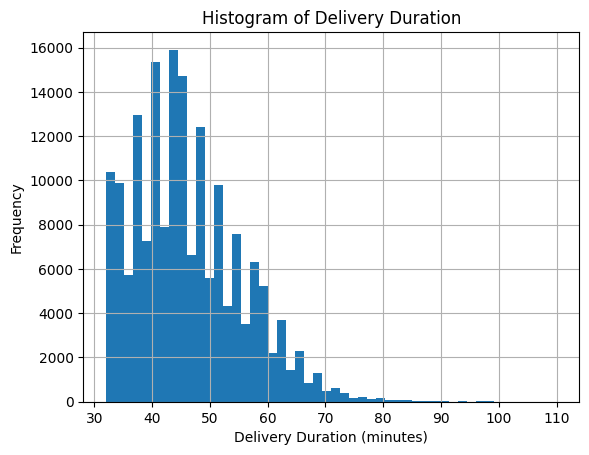

In [40]:
processed_data['delivery_duration'].hist(bins=50)
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Delivery Duration')
plt.show()

In [41]:
processed_data['order_protocol'].value_counts(dropna=False)

order_protocol
1.0    48404
3.0    47125
5.0    41415
2.0    20890
4.0    17246
6.0      678
7.0       19
Name: count, dtype: int64

In [54]:
def get_value_count_na(df, col_name):
    na_count = df[col_name].isna().sum()

    if na_count > 0:
        print(f"Column '{col_name}' has {na_count} missing values.")
    else:
        print(f"Column '{col_name}' has no missing values.")
    value_counts = df[col_name].value_counts(dropna=False)
    value_counts.sort_index(inplace=True)
    
    return value_counts

In [64]:
get_value_count_na(processed_data, 'delivery_duration')

Column 'delivery_duration' has no missing values.


delivery_duration
32.0     6297
33.0     4092
34.0     4661
35.0     5241
36.0     5722
         ... 
101.0       5
102.0       1
103.0       1
105.0       1
110.0       1
Name: count, Length: 74, dtype: int64

In [56]:
processed_data = processed_data[processed_data['total_onshift_dashers']>=0]

In [59]:
processed_data.shape

(175756, 22)

In [78]:
print("Befpore removing negatives:", raw_data.shape)
processed_data_no_neg = processed_data[(processed_data[num_cols]>=0).all(axis=1)].copy()
print("After removing negatives:", processed_data_no_neg.shape)

Befpore removing negatives: (175777, 15)
After removing negatives: (175687, 22)


In [80]:
processed_data_no_neg.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_primary_category                                   int64
order_protocol                                         float64
total_items                                              int64
subtotal                                                 int64
num_distinct_items                                       int64
min_item_price                                           int64
max_item_price                                           int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_store_to_consumer_driving_duration           float64
delivery_duration                                      float64
day_of_week                                            

In [82]:
# convert categorical columns to category dtype
for col in cat_cols:
    processed_data_no_neg[col] = processed_data_no_neg[col].astype('category')

In [83]:
processed_data_no_neg.to_csv('../data/processed/processed_data.csv', index=False)